In [1]:
import numpy as np
import math
import matplotlib
from src.data_management import DataHandler, Settings
from src.FixedFineTuning import ParameterFreeFixedBiasVariation
from src.ConditionalAggressive import ParameterFreeConditionalAggressiveFineTuning, ParameterFreeConditionalAggressiveFineTuningVariation
from src.ConditionalLazy import ParameterFreeConditionalLazyFineTuning, ParameterFreeConditionalLazyFineTuningVariation
from src.UnconditionalAggressive import ParameterFreeAggressiveClassic, ParameterFreeAggressiveVariation
from src.UnconditionalLazy import ParameterFreeLazyClassic, ParameterFreeLazyVariation
from src.plotting import plot_stuff 

In [9]:
# EXP 1 
methods = ['ITL','unconditional_aggressive','unconditional_lazy', 'conditional_aggressive', 'conditional_lazy'] 
# EXP 2 
# methods = ['unconditional_aggressive','unconditional_lazy', 'conditional_aggressive', 'conditional_lazy'] 
# EXP circle
# methods = ['ITL','unconditional_aggressive','unconditional_lazy', 'conditional_aggr_sin_cos', 'conditional_lazy_sin_cos', 'conditional_aggr_fourier', 'conditional_lazy_fourier'] 
# EXP school 
# methods = ['ITL','unconditional_aggressive','unconditional_lazy', 'conditional_aggr_fourier_vec', 'conditional_lazy_fourier_vec'] 


loss_name = 'absolute'    
results = {}

In [10]:
for curr_method in methods: 

    results[curr_method + '_mtl'] = []
    results[curr_method + '_accu'] = []

In [11]:
start = 0
end = 20

# exp = 'exp_synthetic_1_cluster'
# exp = 'exp_synthetic_2_clusters_mean_4'  
# exp = 'exp_synthetic_2_clusters_mean_0'  
# exp = 'exp_synthetic_circle' 
exp = 'exp_real_lenk'
# exp = 'exp_real_schools'


for seed in range(start, end):

    print(f"SEED : {seed} ---------------------------------")
    np.random.seed(seed)
    general_settings = {'seed': seed,
                        'verbose': 1}

    if exp == 'exp_synthetic_1_cluster':

        # synthetic data 1 cluster
        data_settings = {'dataset': 'synthetic-regression',
                            'n_tr_tasks': 350,
                            'n_val_tasks': 100,
                            'n_test_tasks': 80,
                            'n_all_points': 20,
                            'ts_points_pct': 0.5,
                            'n_dims': 20,
                            'noise_std': 0.2}

        settings = Settings(data_settings, 'data')
        settings.add_settings(general_settings)
        data = DataHandler(settings)
        # quantities for generating the feature map
        feature_map_name = 'linear'
        r = None
        W = None
        L = 1
        R = 6
        K = 6 

    elif exp == 'exp_synthetic_2_clusters_mean_4':

        # synthetic data MULTI clusters w_\rho = 4
        data_settings = {'dataset': 'synthetic-regression-multi-clusters',
                            'n_tr_tasks': 350,
                            'n_val_tasks': 100,
                            'n_test_tasks': 80,
                            'n_all_points': 30,
                            'ts_points_pct': 0.5,
                            'n_dims': 20,
                            'noise_std': 0.2}

        settings = Settings(data_settings, 'data')
        settings.add_settings(general_settings)
        data = DataHandler(settings)
        # quantities for generating the feature map
        feature_map_name = 'linear'
        r = None
        W = None
        K = 6 
        L = 1 
        R = 5.5 

    elif exp == 'exp_synthetic_2_clusters_mean_0':

        # synthetic data MULTI clusters w_\rho = 0
        data_settings = {'dataset': 'synthetic-regression-multi-clusters-BIS',
                            'n_tr_tasks': 350,
                            'n_val_tasks': 100,
                            'n_test_tasks': 80,
                            'n_all_points': 20,
                            'ts_points_pct': 0.5,
                            'n_dims': 20,
                            'noise_std': 0.2}

        settings = Settings(data_settings, 'data')
        settings.add_settings(general_settings)
        data = DataHandler(settings)
        # quantities for generating the feature map
        feature_map_name = 'linear'
        r = None
        W = None
        K = 6 
        L = 1 
        R = 6 

    elif exp == 'exp_synthetic_circle':

        # synthetic data - circle
        data_settings = {'dataset': 'circle',
                            'n_tr_tasks': 350,
                            'n_val_tasks': 100,
                            'n_test_tasks': 80,
                            'n_all_points': 20,
                            'ts_points_pct': 0.5,
                            'n_dims': 20,
                            'noise_std': 0.2,
                            'radius_w': 8,
                            'sigma_w': 1}

        settings = Settings(data_settings, 'data')
        settings.add_settings(general_settings)
        data = DataHandler(settings)
        L = 1
        R = 6

    elif exp == 'exp_real_lenk':

        # Lenk dataset
        data_settings = {'dataset': 'lenk',
                            'n_tr_tasks': 540,
                            'n_val_tasks': 0,
                            'n_test_tasks': 0,
                            'ts_points_pct': 0.25
                            }

        settings = Settings(data_settings, 'data')
        settings.add_settings(general_settings)
        data = DataHandler(settings)
        # quantities for generating the feature map
        feature_map_name = 'linear_with_labels'
        r = None
        W = None
        K = 10.5
        L = 1
        R = 1

    elif exp == 'exp_real_schools':

        # Schools dataset
        data_settings = {'dataset': 'schools',
                            'n_tr_tasks': 139,
                            'n_val_tasks': 0,
                            'n_test_tasks': 0,
                            'ts_points_pct': 0.3
                            }

        settings = Settings(data_settings, 'data')
        settings.add_settings(general_settings)
        data = DataHandler(settings)
        # quantities for generating the feature map
        feature_map_name = 'fourier_vector'
        k = 5
        sigma = 250
        d_size = data.features_tr[0].shape[1]
        r = np.random.uniform(low=0., high=2 * np.pi, size=(k, 1))
        W = np.random.randn(k, d_size) * sigma

        K = np.sqrt(2) 
        L = 1
        R = 1

    for curr_method in methods:

        # print(f'method: ', curr_method)
        if curr_method == 'ITL':
            
            model = ParameterFreeFixedBiasVariation(np.zeros(data.features_tr[0].shape[1]), L=L, R=R)
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)

        elif curr_method == 'unconditional_aggressive':
            
            model = ParameterFreeAggressiveClassic(L=L, R=R)
            # model = ParameterFreeAggressiveVariation(L=L, R=R)
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)

        elif curr_method == 'unconditional_lazy':
            
            model = ParameterFreeLazyClassic(L=L, R=R)
            # model = ParameterFreeLazyVariation(L=L, R=R)
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)

        elif curr_method == 'conditional_aggressive':
            
            model = ParameterFreeConditionalAggressiveFineTuning(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            # model = ParameterFreeConditionalAggressiveFineTuningVariation(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)

        elif curr_method == 'conditional_lazy': 
            
            model = ParameterFreeConditionalLazyFineTuning(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            # model = ParameterFreeConditionalLazyFineTuningVariation(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)

        elif curr_method == 'conditional_aggr_sin_cos':
            
            K = 1 
            L = 1
            R = 6
            feature_map_name = 'circle_feature_map'
            r = None
            W = None
            # model = ParameterFreeConditionalAggressiveFineTuning(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            model = ParameterFreeConditionalAggressiveFineTuningVariation(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)
        
        elif curr_method == 'conditional_lazy_sin_cos':

            K = 1 
            L = 1
            R = 6
            feature_map_name = 'circle_feature_map'
            r = None
            W = None
            # model = ParameterFreeConditionalLazyFineTuning(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            model = ParameterFreeConditionalLazyFineTuningVariation(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)    

        elif curr_method == 'conditional_aggr_fourier':

            feature_map_name = 'circle_fourier'
            s_dim = 50
            sigma = 2 * math.pi * 10
            r = 2 * math.pi * np.random.uniform(0.0, 1.0, s_dim)
            W = sigma * np.random.randn(s_dim)
            K = 3.5
            L = 1
            R = 6
            model = ParameterFreeConditionalAggressiveFineTuningVariation(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            # model = ParameterFreeConditionalAggressiveFineTuning(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W) 
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)

        elif curr_method == 'conditional_aggr_fourier_vec':

            model = ParameterFreeConditionalAggressiveFineTuningVariation(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            # model = ParameterFreeConditionalAggressiveFineTuning(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)

        elif curr_method == 'conditional_lazy_fourier':
            
            feature_map_name = 'circle_fourier'
            s_dim = 50
            sigma = 2 * math.pi * 10
            r = 2 * math.pi * np.random.uniform(0.0, 1.0, s_dim)
            W = sigma * np.random.randn(s_dim)
            K = 3.5
            L = 1
            R = 6

            model = ParameterFreeConditionalLazyFineTuningVariation(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W) 
            # model = ParameterFreeConditionalLazyFineTuning(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
    
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)

        elif curr_method == 'conditional_lazy_fourier_vec':

            model = ParameterFreeConditionalLazyFineTuningVariation(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W) 
            # model = ParameterFreeConditionalLazyFineTuning(L=L, R=R, K=K, loss_name=loss_name, feature_map_name=feature_map_name, r=r, W=W)
            mtl_errors, accumulated_errors = model.fit(data)
            results[curr_method + '_mtl'].append(mtl_errors)
            results[curr_method + '_accu'].append(accumulated_errors)


        print(f"method {curr_method} done ")

SEED : 0 ---------------------------------
method ITL done 
inner wealth:     1.00 | meta wealth:     1.00 |       perf:      2.096
method unconditional_aggressive done 
method unconditional_lazy done 
method conditional_aggressive done 
method conditional_lazy done 
SEED : 1 ---------------------------------
method ITL done 
inner wealth:     1.00 | meta wealth:     1.00 |       perf:      2.097
method unconditional_aggressive done 
method unconditional_lazy done 
method conditional_aggressive done 
method conditional_lazy done 
SEED : 2 ---------------------------------
method ITL done 
inner wealth:     1.00 | meta wealth:     1.00 |       perf:      2.097
method unconditional_aggressive done 
method unconditional_lazy done 
method conditional_aggressive done 
method conditional_lazy done 
SEED : 3 ---------------------------------
method ITL done 
inner wealth:     1.00 | meta wealth:     1.00 |       perf:      2.101
method unconditional_aggressive done 
method unconditional_lazy 

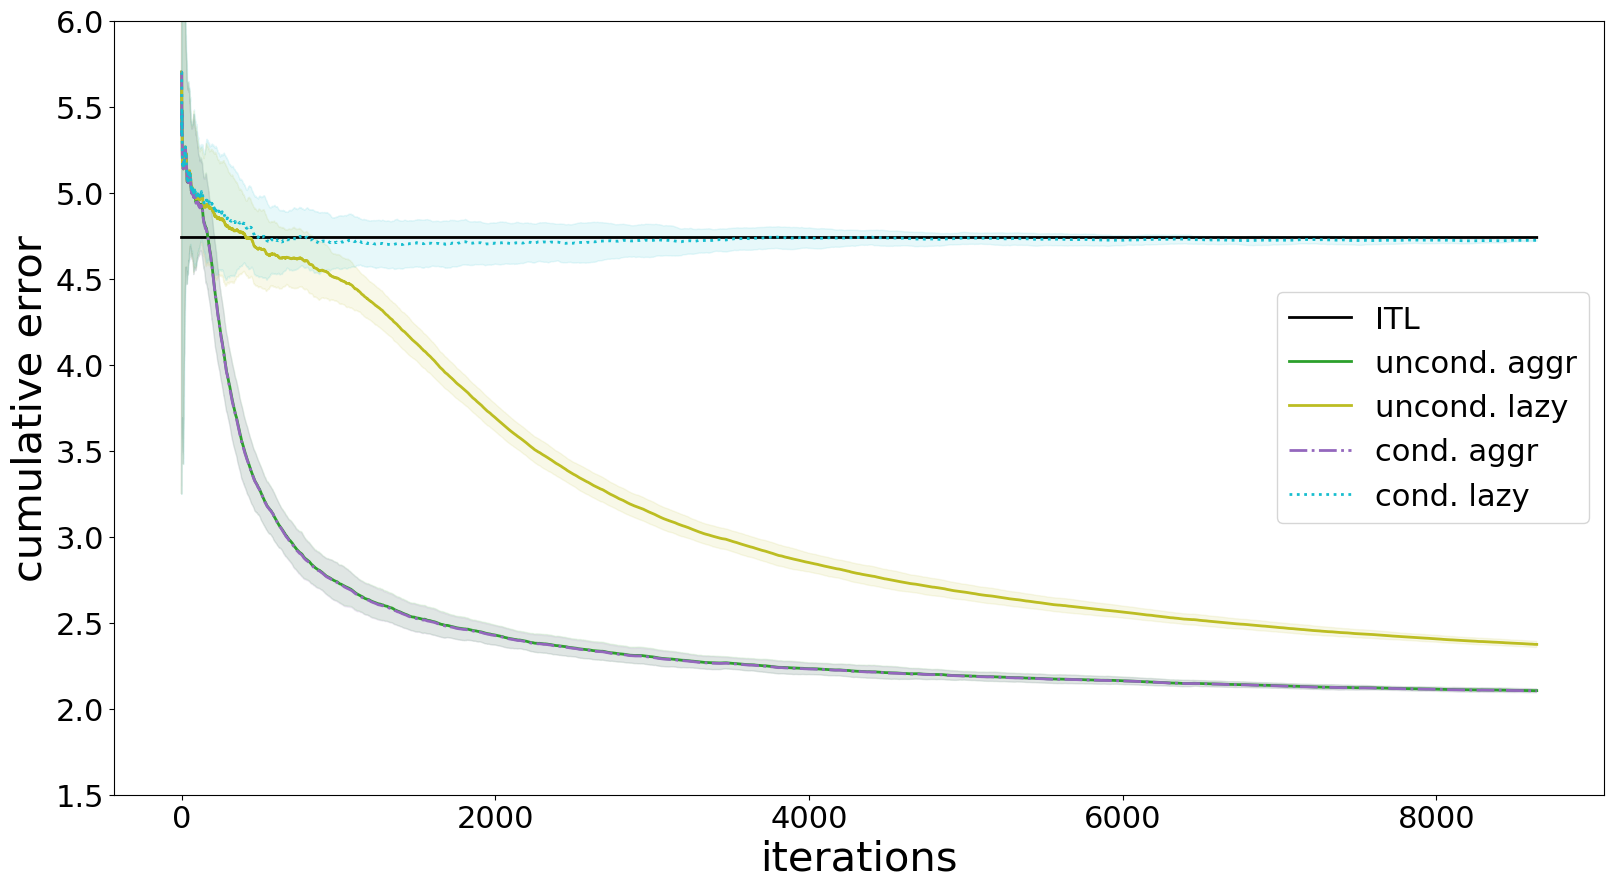

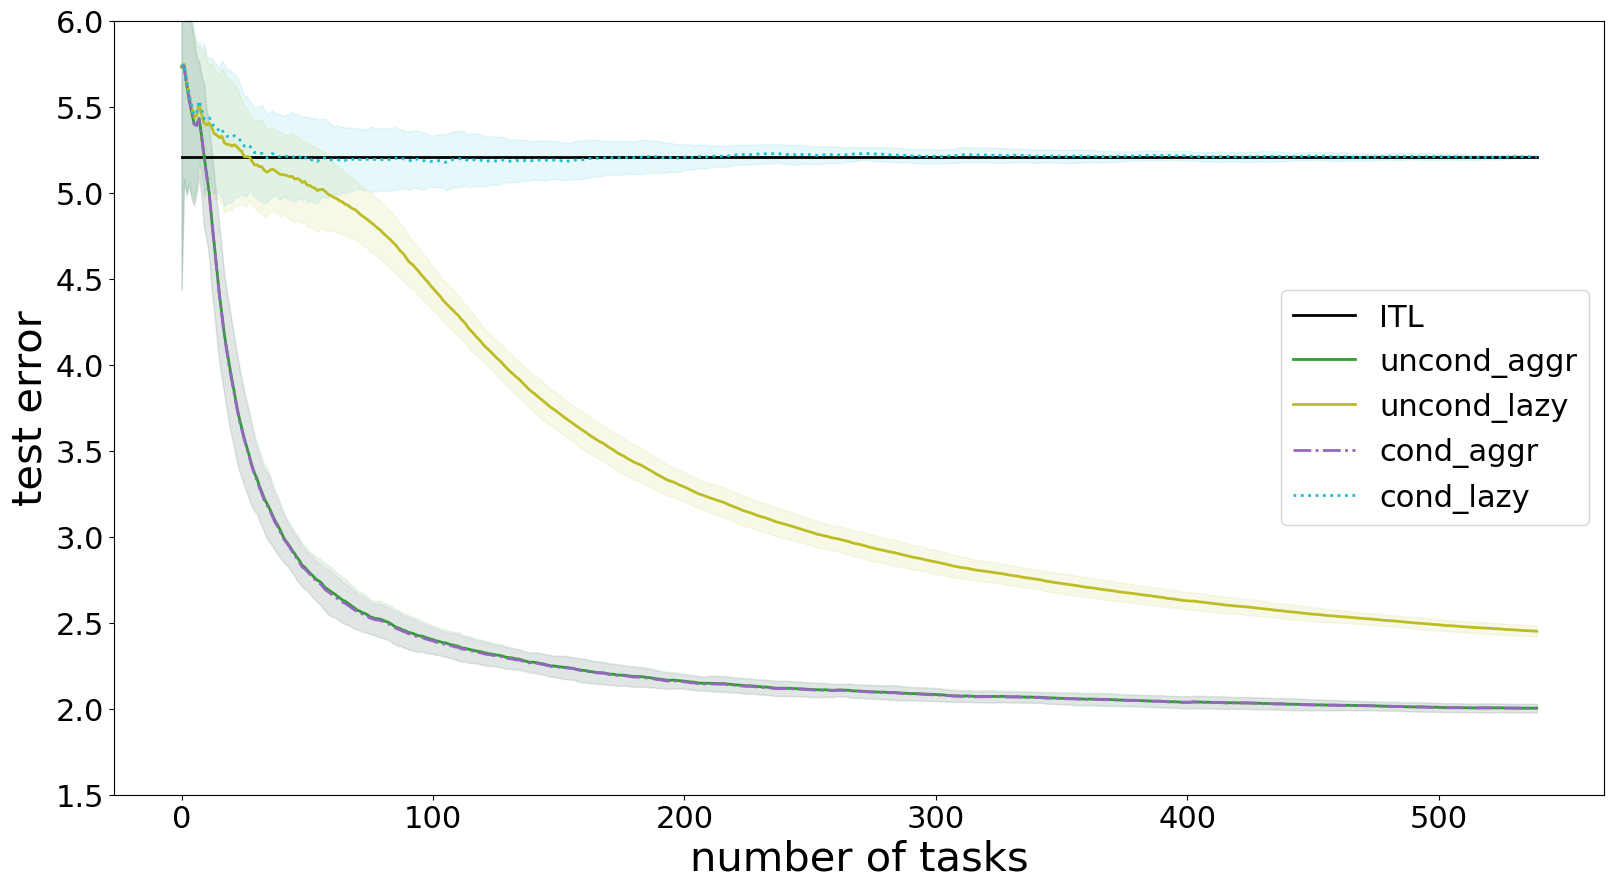

In [12]:
dataset = 'Lenk-KT-20201005-triple-data'
plot_stuff(results, methods, dataset, bottom_a = 1.5, top_a =6, bottom_b = 1.5, top_b = 6)